### <b> Overview


1. Loading trachea, lung, metadata, and annotations data (https://figshare.com/articles/dataset/Single-cell_RNA-seq_data_from_Smart-seq2_sequencing_of_FACS_sorted_cells_v2_/5829687)
2. Filtering
3. Normalization
4. Transformation
5. Dimensionality reduction analysis (PCA and UMAP) / visualization
6. Clustering data and gene analysis / visualization

In [1]:
%%bash
# Run this everytime you restart your kernel or relaunch the server
# Install required packages
pip install scprep umap-learn phenograph tasklogger graphtools

  Using cached scprep-1.2.3-py3-none-any.whl (94 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
  Using cached PhenoGraph-1.5.7-py3-none-any.whl (159 kB)
  Using cached tasklogger-1.2.0-py3-none-any.whl (14 kB)
  Using cached graphtools-1.5.3-py3-none-any.whl (45 kB)
  Using cached numba-0.60.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
  Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
  Using cached Deprecated-1.2.15-py2.py3-none-any.whl (9.9 kB)
  Using cached PyGSP-0.5.1-py2.py3-none-any.whl (1.8 MB)
  Using cached igraph-0.11.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached llvmlite-0.43.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
  Using cached wrapt-1.17.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Using cached t

In [2]:
import pandas as pd
import numpy as np
import scprep, umap, graphtools as gt, phenograph, tasklogger
import matplotlib.pyplot as plt
from sklearn import cluster
%matplotlib inline

#### <b> Loading data (csv/tsv/txt)

In [3]:

# Load Tabula Muris dataset for two tissue types
lung_data = scprep.io.load_csv('Lung-counts.csv', cell_axis='row', sparse=True).transpose()


trachea_data = scprep.io.load_csv('Trachea-counts.csv', cell_axis='row', sparse=True).transpose()

print(trachea_data.shape)
print(lung_data.shape)


(1391, 23433)
(1923, 23433)


#### <b> Combining batches

In [4]:
## TO DO

data = [lung_data, trachea_data]
batch_labels = ['lung', 'trachea']

data, sample_labels = scprep.utils.combine_batches(data, batch_labels)


In [5]:
lookup = pd.Series(data.index).apply(lambda x: x.split('.')[1])

metadata = pd.read_csv('metadata_FACS.csv', index_col=0).loc[lookup.values].reset_index()
metadata.index = data.index

annotations = pd.read_csv('annotations_facs.csv', dtype=object)

# clean cell names in annotations to match data index format
annotations['cleaned_cell'] = annotations['cell'].apply(lambda x: x.split('.')[1])
# filter annotations to only include cells in our data
annotations = annotations[annotations['cleaned_cell'].isin(lookup.values)]
# remove any duplicates based on cleaned cell names
annotations = annotations.drop_duplicates(subset=['cleaned_cell'])
# set index to match data index
annotations = annotations.set_index('cleaned_cell')
annotations = annotations.reindex(lookup.values)
annotations.index = data.index


print(f"Data rows: {data.shape[0]}, Metadata rows: {metadata.shape[0]}, Annotations rows: {annotations.shape[0]}")


# annotations.head()


Data rows: 3314, Metadata rows: 3314, Annotations rows: 3314


after filtering:  (3141, 17243)


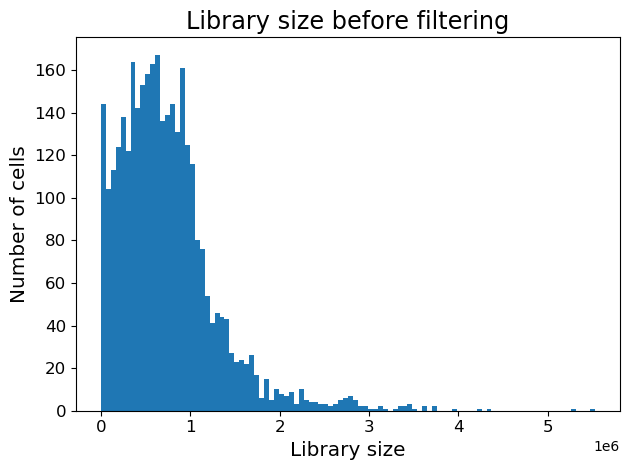

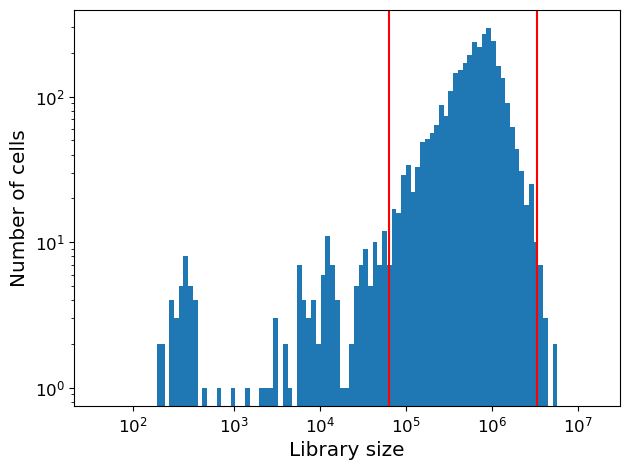

In [6]:

scprep.plot.plot_library_size(data, log=False, title='Library size before filtering')

percentiles = (4.7, 99.5) # ( ..select low.. , ..select high..  )



scprep.plot.plot_library_size(data, percentile=percentiles)

data, metadata, annotations = scprep.filter.filter_library_size(data, metadata, annotations, percentile=percentiles)

# scprep.plot.histogram(scprep.measure.gene_capture_count(data), log=True,
#                       title="Gene capture before filtering",
#                      xlabel='# of cells with nonzero expression',
#                      ylabel='# of genes')

# scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
#                       cutoff = 8,
#                       log=True,
#                       title="Gene capture before filtering",
#                      xlabel='# of cells with nonzero expression',
#                      ylabel='# of genes')

cutoff = 8 
data = scprep.filter.filter_rare_genes(data, min_cells=cutoff)

print("after filtering: ", data.shape)
# scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
#                       cutoff = 8,
#                       log=True,
#                       title="Gene capture before filtering",
#                      xlabel='# of cells with nonzero expression',
#                      ylabel='# of genes')

In [7]:


data, metadata['library_size'] = scprep.normalize.library_size_normalize(data, return_library_size=True)


# scprep.plot.histogram(data.mean(axis=0), log='y',
#                       title= "Mean Expression of Genes",
#                      xlabel= "Mean expression value",
#                      ylabel= "# of Genes")

data = scprep.transform.sqrt(data)

# scprep.plot.histogram(data.mean(axis=0), log='y',
#                       title= "gene counts after transormation",
#                      xlabel= "Mean expression value",
#                      ylabel= "# of Genes")

## Save the data and metadata dataframes into pickle.gz files you can open later
data.to_pickle("data.pickle.gz") #file.pickle.gz
metadata.to_pickle("metadata.pickle.gz")  #file.pickle.gz
annotations.to_pickle("annotations.pickle.gz")


### <b> 5. Saving the output

### <b> 6. Principle Components Analysis (PCA) and UMAP

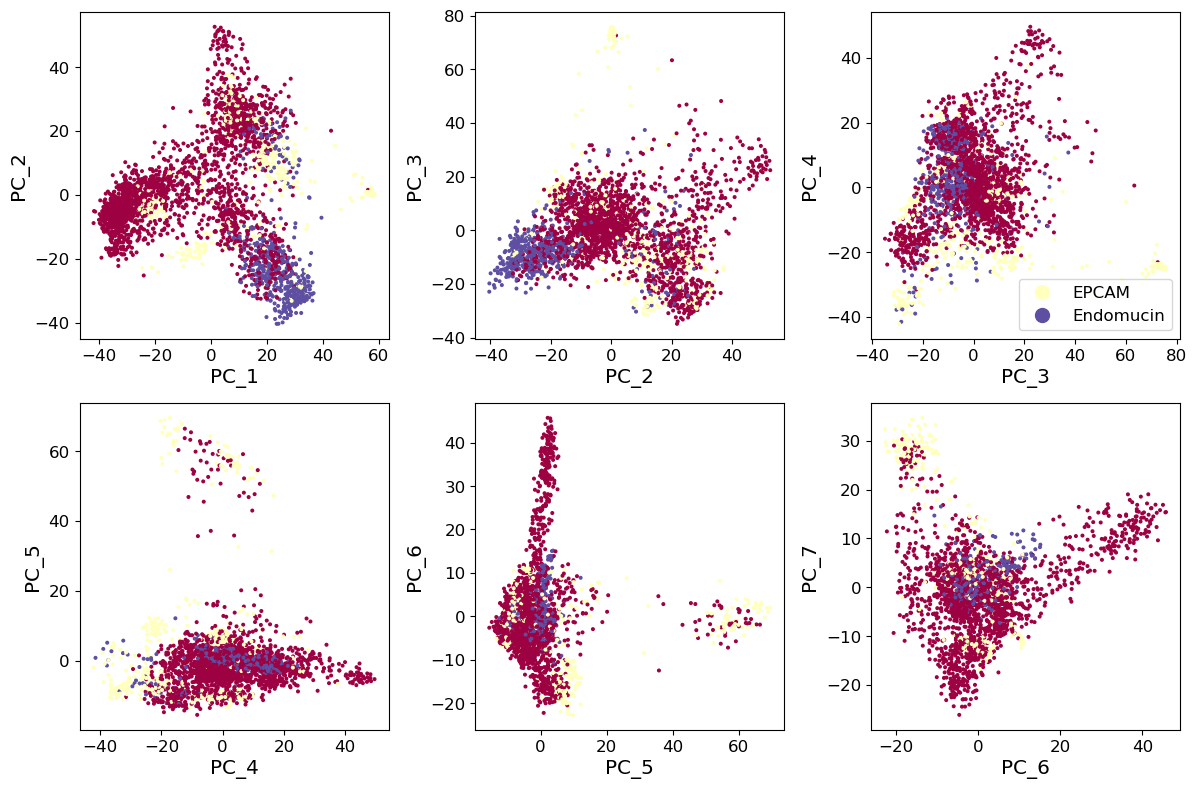

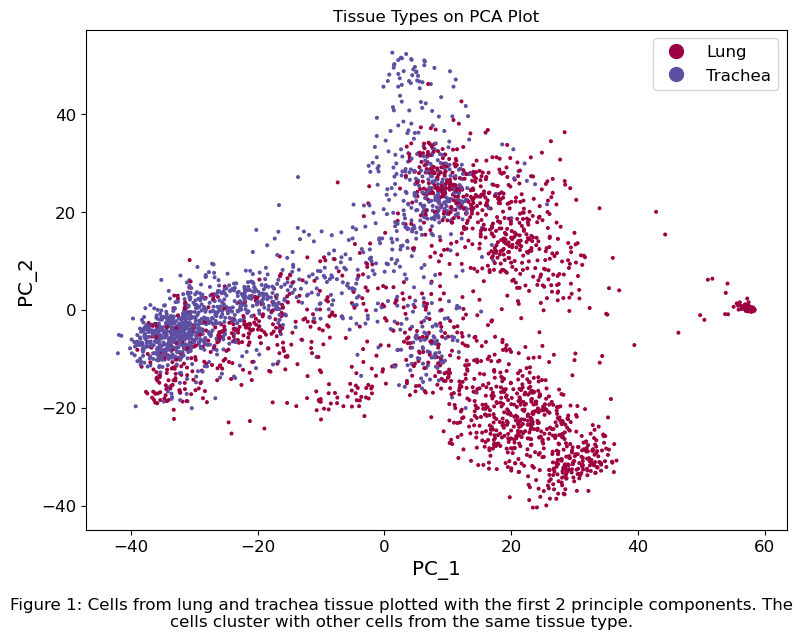

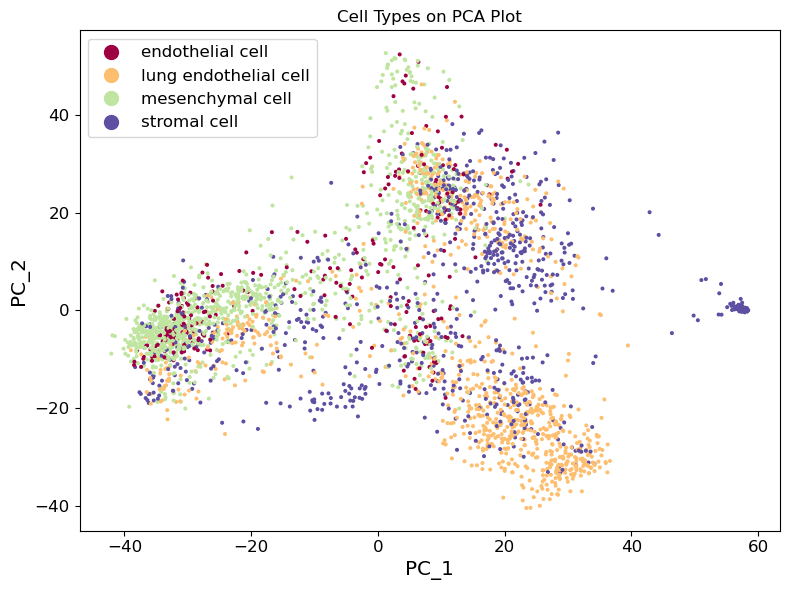

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scprep
import seaborn as sns 
%matplotlib inline

import umap
import os


## load saved data, fill in with the paths to the appropriate pickle files you chose above
data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')
annotations = pd.read_pickle('annotations.pickle.gz')

data_pca = scprep.reduce.pca(data, n_components=50, method='dense')




fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    # only plot a legend on one axis
    legend = True if i == 2 else False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=metadata['subtissue'],
                        cmap='Spectral', ax=ax,
                        xlabel="PC_" + str(i+1), ylabel="PC_" + str(i+2), legend=legend)
fig.tight_layout() 


fig, axes = plt.subplots(figsize=(8,6))
# This makes it easier to iterate through the axes
axes.set_title('Tissue Types on PCA Plot')

fig.text(0.5, -0.05, "Figure 1: Cells from lung and trachea tissue plotted with the first 2 principle components. The cells cluster with other cells from the same tissue type.", wrap=True, horizontalalignment='center', fontsize=12)

scprep.plot.scatter(data_pca.iloc[:,0], data_pca.iloc[:,1], c=metadata['tissue'],
                    cmap='Spectral', ax=axes,
                    xlabel="PC_1", ylabel="PC_2", legend=True)
fig.tight_layout() 


fig, axes = plt.subplots(figsize=(8,6))
# This makes it easier to iterate through the axes
axes.set_title('Cell Types on PCA Plot')
# axes = axes.flatten()

# for i, ax in enumerate(axes):
    # only plot a legend on one axis
    # legend = True if i == 2 else False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
# fig.text(0.5, -0.05, "Figure 2: Various cell types from both lung and trachea tissue plotted with the first 2 principle components. The cell types are separated into clusters.", wrap=True, horizontalalignment='center', fontsize=12)
# fig.
scprep.plot.scatter(data_pca.iloc[:,0], data_pca.iloc[:,1], c=annotations['cell_ontology_class'],
                    cmap='Spectral', ax=axes,
                    xlabel="PC_1", ylabel="PC_2", legend=True)

fig.tight_layout() 



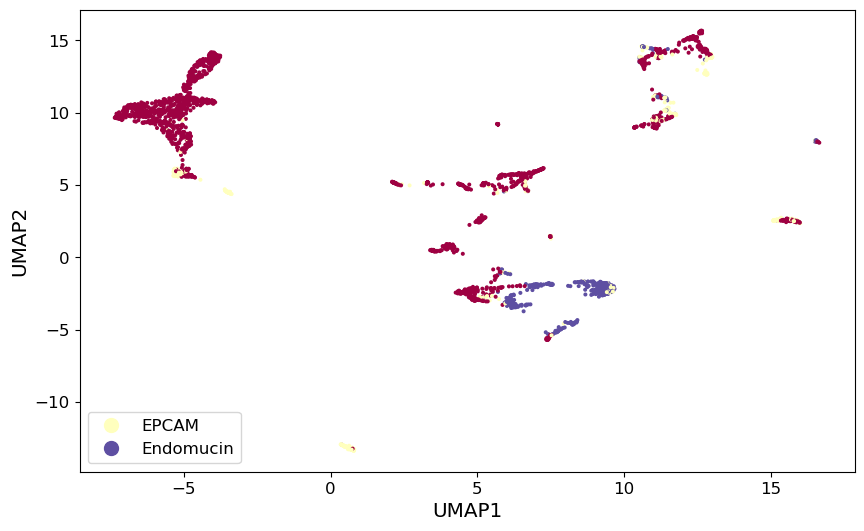

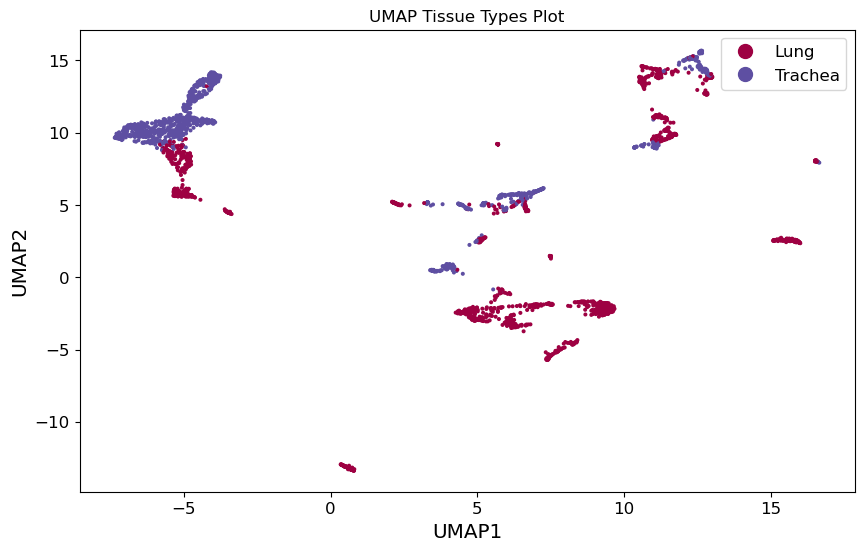

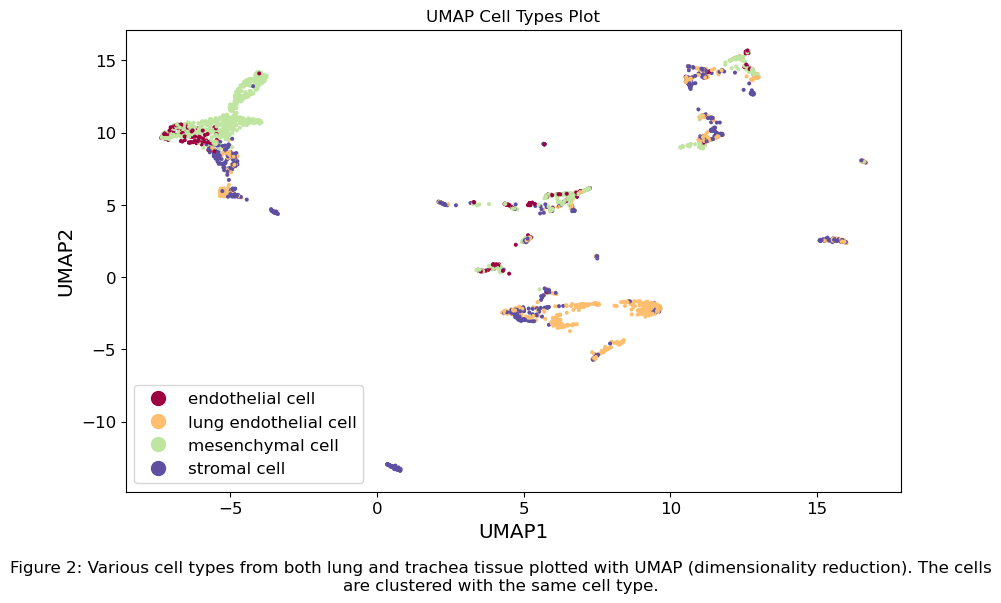

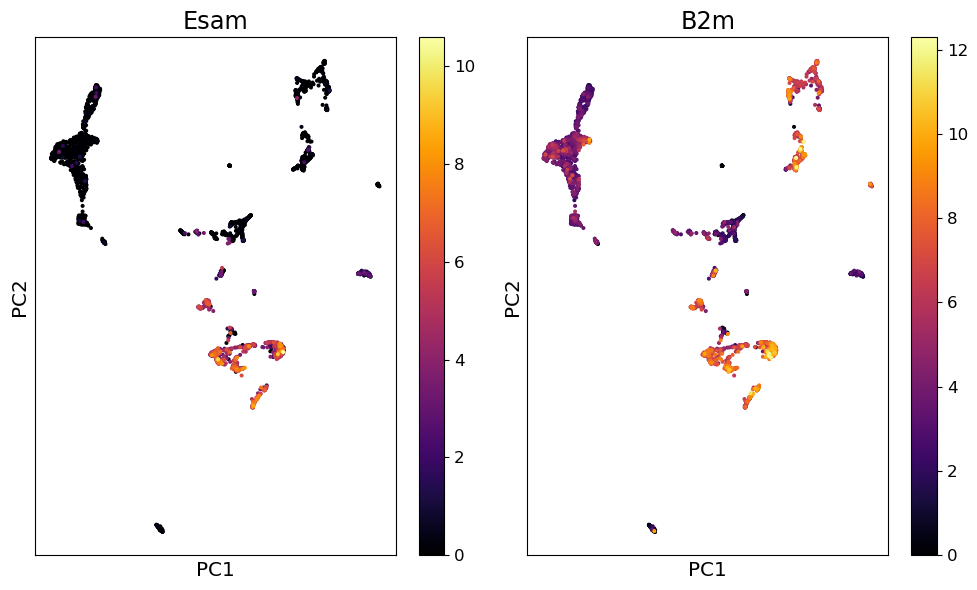

In [9]:
import umap.umap_ as umap
%matplotlib inline

data_umap = umap.UMAP(n_neighbors=95).fit_transform(data_pca.iloc[:,:50])   # 24, 27,49,50,69,73,79, 82,86

data_umap = pd.DataFrame(data_umap, index = data.index)

# **colored by subtissue** 
fig, ax = plt.subplots(figsize=(10,6)) ## feel free to adjust size

scprep.plot.scatter2d( 
  data_umap, cmap='Spectral',
  c=metadata['subtissue'], ax=ax,
  label_prefix="UMAP"
)


fig, ax = plt.subplots(figsize=(10,6)) ## feel free to adjust size
ax.set_title("UMAP Tissue Types Plot")
scprep.plot.scatter2d( 
  data_umap, cmap='Spectral',
  c=metadata['tissue'], ax=ax,
  label_prefix="UMAP"
)


fig, ax = plt.subplots(figsize=(10,6)) ## feel free to adjust size
ax.set_title("UMAP Cell Types Plot")
fig.text(0.5, -0.05, "Figure 2: Various cell types from both lung and trachea tissue plotted with UMAP (dimensionality reduction). The cells are clustered with the same cell type.", wrap=True, horizontalalignment='center', fontsize=12)

scprep.plot.scatter2d( 
  data_umap, cmap='Spectral',
  c=annotations['cell_ontology_class'], ax=ax,
  label_prefix="UMAP"
)



genes_for_plotting = ['Esam', 'B2m']
# Plot two subplots of the UMAP coordinates
# coloring by Sp1 and Rn45s
fig, axes = plt.subplots(1, 2, figsize=(10,6))

for gene, ax in zip(genes_for_plotting, axes.flatten()):
    expression = scprep.select.select_cols(data, exact_word=gene)
    sort_index = expression.sort_values().index

    scprep.plot.scatter2d(data_umap.loc[sort_index], c=expression.loc[sort_index],
                          shuffle=False, title=gene, 
                          label_prefix='PC', ticks=None, ax=ax)
                          
fig.tight_layout()


Calculating phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.06867408752441406 seconds
Jaccard graph constructed in 0.714052677154541 seconds
Wrote graph to binary file in 0.06414151191711426 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.932448
Louvain completed 21 runs in 0.6894733905792236 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.7479016780853271 seconds
Calculated phenograph in 1.75 seconds.
Calculating KMeans...


/srv/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Calculated KMeans in 0.77 seconds.
Calculating Spectral clustering...


/srv/conda/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Calculated Spectral clustering in 2.68 seconds.


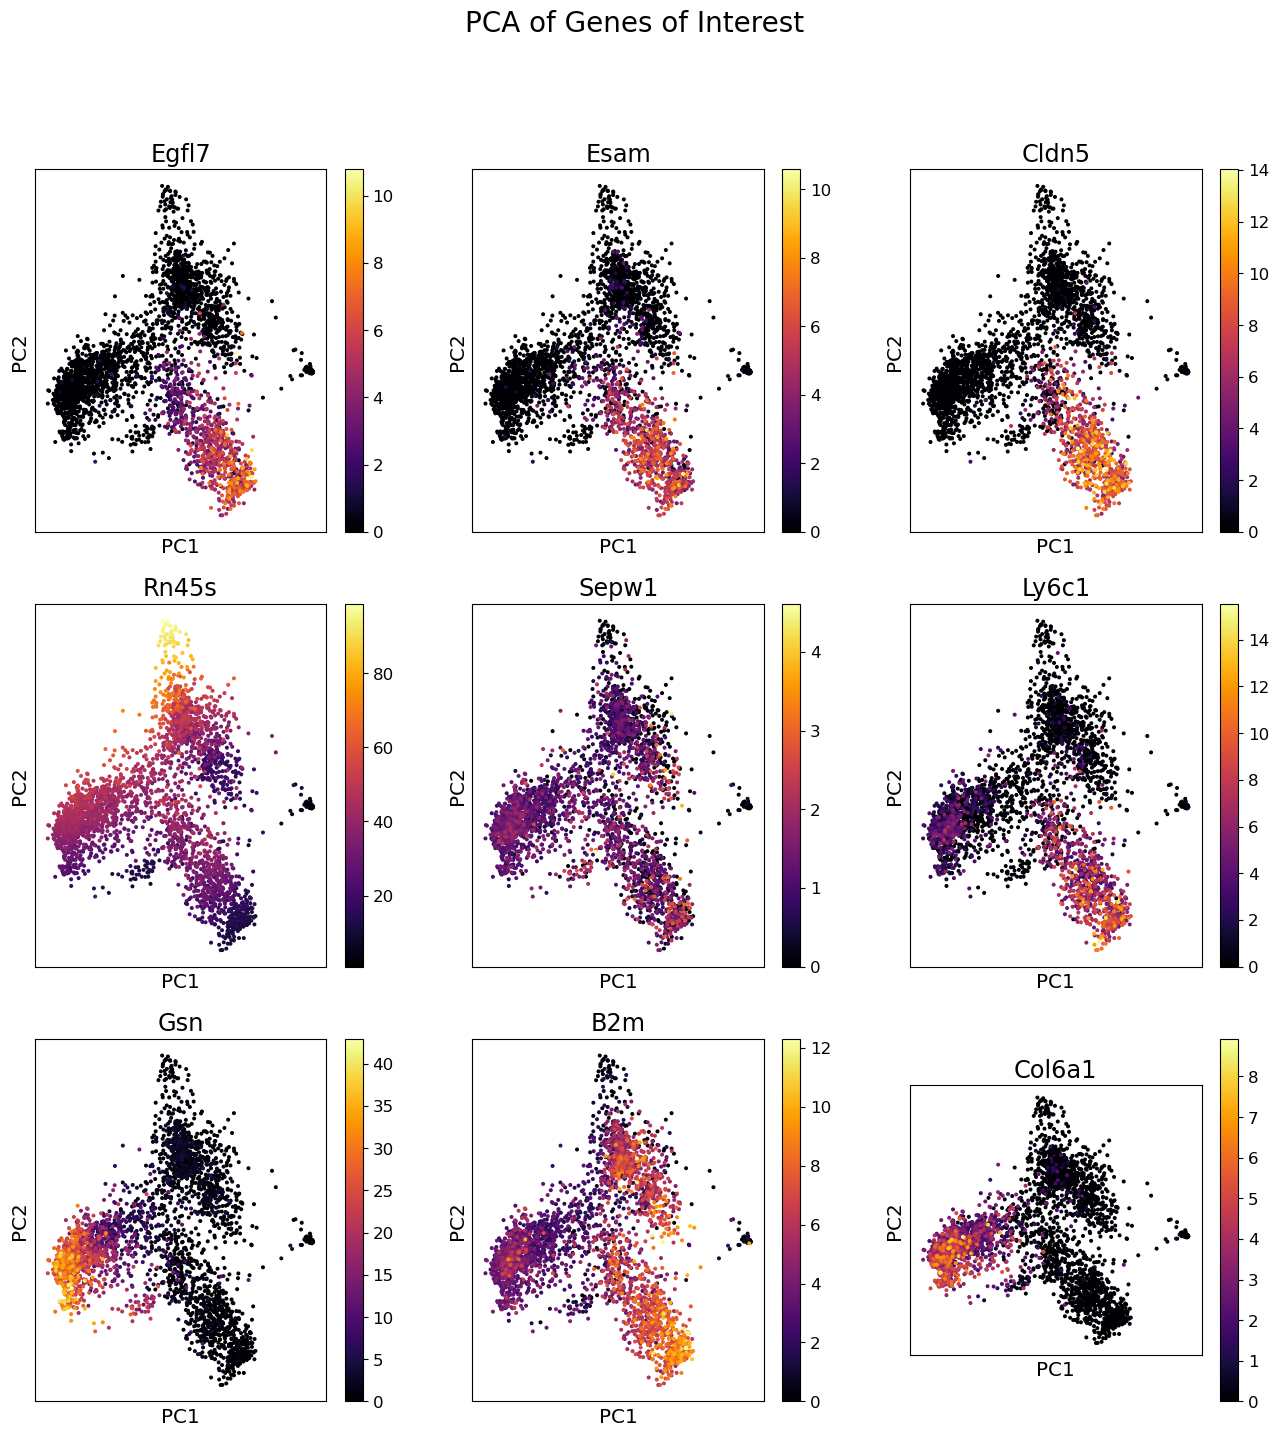

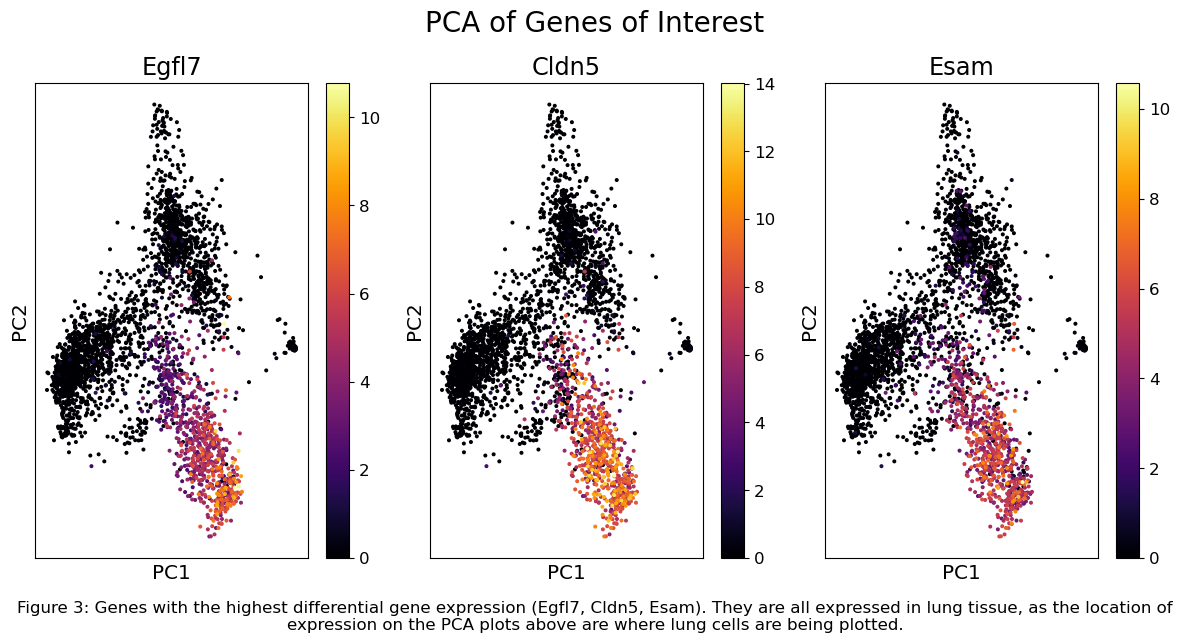

In [10]:
import pandas as pd
import numpy as np
import scprep, umap 
import sklearn
import sklearn.cluster
import sklearn.manifold
import graphtools as gt
import phenograph
import matplotlib.pyplot as plt
import tasklogger

%matplotlib inline


with tasklogger.log_task("phenograph"):
    phenograph_clusters, _, _ = phenograph.cluster(data_pca)
    
with tasklogger.log_task("KMeans"):
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters = 4).fit_predict(data_pca)
    
G = gt.Graph(data_pca)
G_igraph = G.to_igraph()

with tasklogger.log_task("Spectral clustering"):
    spec_op = sklearn.cluster.SpectralClustering(n_clusters = 4, affinity='precomputed')
    spectral_clusters = spec_op.fit_predict(G.K)

clusterings = {'Phenograph':phenograph_clusters,
               'KMeans':kmeans_clusters,
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_pca.iloc[:,0])
    clusterings[alg] = cl_nu



gene_list = ["Egfl7", "Esam", "Cldn5", "Rn45s", "Sepw1", "Ly6c1", "Gsn", "B2m", "Col6a1"]

# Let's look at the dataframe 'data', subsetted to just the genes we've listed above
data[gene_list]

fig, axes = plt.subplots(3,3, figsize=(16,16))
fig.suptitle('PCA of Genes of Interest', fontsize=20)
# fig.text(0.5, -0.05, "Figure 3: Various cell types from both lung and trachea tissue plotted with the first 2 principle components. The cell types are separated into clusters.", wrap=True, horizontalalignment='center', fontsize=12)

for gene, ax in zip(gene_list, axes.flatten()):
  ## TO DO ##
  expression = scprep.select.select_cols(data, exact_word=gene)
 
  # we will sort cells by maximum expression so we can see where the gene is expressed
  sort_index = expression.sort_values().index
    
  scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                       title=gene, ticks=None, label_prefix='PC', ax= ax)

gene_list = ["Egfl7", "Cldn5", "Esam"]
data[gene_list]
fig, axes = plt.subplots(1, 3, figsize=(12,6))
ax.set_aspect('equal', adjustable='box')
fig.suptitle('PCA of Genes of Interest', fontsize=20)
fig.text(0.5, -0.05, "Figure 3: Genes with the highest differential gene expression (Egfl7, Cldn5, Esam). They are all expressed in lung tissue, as the location of expression on the PCA plots above are where lung cells are being plotted.", wrap=True, horizontalalignment='center', fontsize=12)

for gene, ax in zip(gene_list, axes.flatten()):
  ## TO DO ##
  expression = scprep.select.select_cols(data, exact_word=gene)
 
  # we will sort cells by maximum expression so we can see where the gene is expressed
  sort_index = expression.sort_values().index
    
  scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                       title=gene, ticks=None, label_prefix='PC', ax= ax)
fig.tight_layout()
# metadata.head()

# fig, axes = plt.subplots(1,3, figsize=(16,16), subplot_kw={'aspect':'equal'})

# for ax, algorithm in zip(axes.flatten(), clusterings):
#   scprep.plot.scatter2d(data_pca, c=clusterings[algorithm], cmap=plt.cm.rainbow,
#                         title='{} - ({})'.format(algorithm, len(np.unique(clusterings[algorithm]))),
#                         ticks=False, label_prefix="PCA", legend=False, discrete=True,
#                         ax=ax)


In [11]:
clusters = clusterings["KMeans"]

data_sparse = scprep.utils.SparseDataFrame(data)

curr_cluster = 1
ttest_results = scprep.stats.differential_expression(data_sparse[clusters == curr_cluster],
                                                         data_sparse[clusters != curr_cluster],
                                                         measure='ttest')

top_genes = ttest_results['ttest'].abs().sort_values(ascending=False)[:50]

top_genes.head(n=20)

Egfl7       59.487977
Cldn5       57.040581
Esam        54.775761
Ramp2       53.287951
Slc9a3r2    51.827318
Sdpr        50.867135
Icam2       50.064242
Calcrl      49.607157
Lgals1      45.103547
Gsn         44.410930
Cav1        44.264378
Tspan7      44.251629
Gpr116      44.074401
Lrp1        43.590105
H2-D1       43.088021
Tspan13     43.008112
Pecam1      41.739883
S1pr1       41.359451
Epas1       41.301988
Ly6c1       41.264598
Name: ttest, dtype: float64